### **Data Anonymization Evaluation (summary)**

In [ ]:
%pip install transformers torch

In [ ]:
%pip install python-Levenshtein

In [2]:
import pandas as pd
import Levenshtein
import numpy as np
import os
import ast
from tqdm import tqdm

#### Reading datasets

In [3]:
df = pd.read_json("hf://datasets/AGBonnet/augmented-clinical-notes/augmented_notes_30K.jsonl", lines=True)

C:\Users\rafau\Documents\PythonProjects\DataSanitization\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
df_anonym = pd.read_csv("../datasets/summaries/summaries_anonymized_merged.csv")

In [10]:
ast.literal_eval(df_anonym['sensitive_entity_note'][0])

{'1.0',
 '10 years',
 '4.4 cm',
 '65-year-old',
 'Gore',
 'He',
 'His',
 'a covered, self - expanding stent',
 'a less invasive treatment',
 'a pulsating mass',
 'a saccular dilatation in the tibioperoneal trunk',
 'a swelling of the posterior surface',
 'active infections',
 'an intestinal tumor',
 'bacterial endocarditis',
 'difficulties',
 'ec',
 'gore viabahn',
 'his',
 'male',
 'one',
 'one varicose veins surgery',
 'reduction of the distal diameter',
 'the aneurysm',
 'the aneurysm sac',
 'the inflammatory / infectious pathophysiology',
 'the pseudoaneurysm',
 'the symptoms',
 'treatment',
 'two',
 'two abdominal operations',
 'two mitral valve replacement operations'}

### **Average Levenshtein Index of Dissimilarity (ALID)**
<br>

Compute LSI for each sensitive entity of observation:
$$
LSI = \max_{j=1}^{L-e} LR_a(se_i, w_j)
$$

Next compute the average of each LSI calculated before:
$$
ALID = (1 - \langle S \rangle) \times 100
$$



In [29]:
def LRa(a: str, b: str) -> float:
    """
    Levenshtein Ratio:
    LRa(a, b) = 1 - LD(a, b) / max(len(a), len(b))
    """
    len_a = len(a)
    len_b = len(b)
    if max(len_a, len_b) == 0:
        return 1.0  # both strings are empty
    ld = Levenshtein.distance(a, b)
    return 1 - (ld / max(len_a, len_b))

def compute_lsi(entity: str, text_anon: str) -> float:
    e_len = len(entity)
    max_lra = 0.0
    for i in range(len(text_anon) - e_len + 1):
        window = text_anon[i:i + e_len]
        lra = LRa(entity, window)
        max_lra = max(max_lra, lra)
    return max_lra

def compute_average_levenshtein_index_of_dissimilarity(anonym_note: str, sensitive_entity_note: list) -> float:
    lsi_values = [compute_lsi(ent, anonym_note) for ent in sensitive_entity_note]
    average_lsi = np.mean(lsi_values)
    ALID = (1 - average_lsi) * 100
    return ALID

In [30]:
alid = compute_average_levenshtein_index_of_dissimilarity(df_anonym['summary'][0], ast.literal_eval(df_anonym['sensitive_entity_note'][0]))
print(f"ALID: {alid:.2f}%")

ALID: 54.79%


### **Levenshtein Recall (LR)**

<br>
To calculate LR, each LSI in S is compared to a selected similarity threshold, $ths$, set to 0.85:

$$
LR@ths = \frac{ \sum_{i=1}^{l} (S_i < ths) }{l} \times 100
$$

In [31]:
def compute_LR_ths(anonym_note: str, sensitive_entity_note: list, ths=0.85) -> float:
    LSI_scores = []
    for entity in sensitive_entity_note:
        LSI_scores.append(compute_lsi(entity, anonym_note))

    # Compute recall
    num_deidentified = sum(1 for s in LSI_scores if s < ths)
    recall = (num_deidentified / len(sensitive_entity_note)) * 100
    return recall

In [32]:
lr_score = compute_LR_ths(df_anonym['summary'][1], ast.literal_eval(df_anonym['sensitive_entity_note'][0]))
print(f"Levenshtein Recall: {lr_score:.2f}%")

Levenshtein Recall: 96.88%


### **Levenshtein Recall Quasi Identifier (LRQI)**

The LRQI is calculated similarly to the LR but only considering quasi-identifiers.

$$
\text{LRQI}@ths = \frac{ \sum_{k=1}^{l_{qi}} (S_k < ths) }{l_{qi}} \times 100
$$

In [33]:
import json
import difflib

def compute_LRQI_ths(anonym_note: str, sensitive_entity_note: list, json_summary: str, ths=0.85) -> float:

    def extract_qi_values_from_json(json_str: str) -> list:
        try:
            data = json.loads(json_str)
        except Exception as e:
            return []

        qi_values = []

        # Extract patient information
        pi = data.get("patient information", {})
        for key in ["age", "sex", "ethnicity", "occupation", "socio economic context"]:
            v = pi.get(key)
            if v and v.lower() != "none":
                qi_values.append(v)

        # Extract patient medical history
        pmh = data.get("patient medical history", {})

        if isinstance(pmh, dict):

            # Physiological context
            phsy = pmh.get("physiological context")
            if phsy is not None:
                if isinstance(phsy, str):
                    phsy = phsy.split(",")
                elif isinstance(phsy, dict):
                    phsy = list(phsy.values())
                else:
                    phsy = []
                for p in phsy:
                    qi_values.append(p)

            # Psychological context
            psych = pmh.get("psychological context")
            if psych is not None:
                if isinstance(psych, str):
                    psych = psych.split(",")
                elif isinstance(psych, dict):
                    psych = list(psych.values())
                else:
                    psych = []
                for p in psych:
                    qi_values.append(p)

        elif isinstance(pmh, str) and pmh.lower() != "none":
            qi_values.append(pmh)

        # Extract symptoms
        for s in data.get("symptoms", []):
            if s is not None and isinstance(s, dict):
                if s.get("time") and s["time"].lower() != "none":
                    qi_values.append(s["time"])
                if s.get("location") and s["location"].lower() != "none":
                    qi_values.append(s["location"])
                if s.get("name of symptom") and s["name of symptom"].lower() != "none":
                    for symptom in s.get("name of symptom").split(","):
                        qi_values.append(symptom)

        # Extract treatments
        for t in data.get("treatments", []):
            if t is not None and isinstance(t, dict):
                if t.get("name") and t["name"].lower() != "none":
                    qi_values.append(t["name"])
                if t.get("dosage") and t["dosage"].lower() != "none":
                    qi_values.append(t["dosage"])
                if t.get("reaction to treatment") and t["reaction to treatment"].lower() != "none":
                    for reaction in t.get("reaction to treatment").split(","):
                        qi_values.append(reaction)
                if t.get("time") and t["time"].lower() != "none":
                    qi_values.append(t["time"])
        return qi_values


    def filter_qi_entities(sensitive_entities, qi_values, threshold=0.5):
        filtered = []
        se_lower = [e.lower() for e in sensitive_entities]

        for qi in qi_values:
            qi_low = qi.lower()
            for ent in se_lower:
                if qi_low in ent or ent in qi_low:
                    filtered.append(ent)

        for qi in qi_values:
            qi_low = qi.lower()
            for se in sensitive_entities:
                se_low = se.lower()
                ratio = difflib.SequenceMatcher(None, qi_low, se_low).ratio()
                if ratio >= threshold:
                    filtered.append(se)

        return list(set(filtered))

    qi_vals = extract_qi_values_from_json(json_summary)

    if len(qi_vals) == 0: return -1

    qi_entities = filter_qi_entities(sensitive_entity_note, qi_vals)

    return compute_LR_ths(anonym_note, qi_entities)

In [34]:
lr_score = compute_LRQI_ths(anonym_note=df_anonym['summary'][0], sensitive_entity_note=ast.literal_eval(df_anonym['sensitive_entity_note'][0]),
                            json_summary=df['summary'][df_anonym['index'][0]])
print(f"Levenshtein Recall Quasi Identifiers: {lr_score:.2f}%")

Levenshtein Recall Quasi Identifiers: 87.50%


### **Jaccard Similarity Coefficient (JSC)**

Let C11 be the number of classes where both representations have a value of 1 and C01 + C10 be the number of classes where the representations have different values:

$$
\text{JSC@thb} = \frac{C_{11}}{C_{11} + C_{01} + C_{10}} \times 100
$$


In [35]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, BertForSequenceClassification

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("AkshatSurolia/ICD-10-Code-Prediction")
model = BertForSequenceClassification.from_pretrained("AkshatSurolia/ICD-10-Code-Prediction")
model.to(device)
model.eval()
config = model.config

def chunk_text_ids(text: str, max_tokens=512):
    inputs = tokenizer(text, add_special_tokens=False)
    input_ids = inputs['input_ids']
    max_len = max_tokens - 2  # reserved for special tokens
    chunks = [input_ids[i:i+max_len] for i in range(0, len(input_ids), max_len)]
    return chunks

def aggregate_logits_from_chunks(text) -> tuple[torch.Tensor, torch.Tensor]:
    chunks = chunk_text_ids(text, max_tokens=512)
    total_logits = None

    for chunk in chunks:
        # add CLS e SEP token id
        input_ids = [tokenizer.cls_token_id] + chunk + [tokenizer.sep_token_id]
        input_tensor = torch.tensor([input_ids])  # batch size 1

        with torch.no_grad():
            logits = model(input_tensor).logits.squeeze(0)  # [num_classes]

        if total_logits is None:
            total_logits = logits
        else:
            total_logits += logits  # sum logits

    return total_logits

def compute_jaccard_similarity_coefficient(original_note: str, anonym_note: str, thb: float = 0.0005) -> float:

    final_logits_original_note = aggregate_logits_from_chunks(original_note)
    final_logits_masked_note = aggregate_logits_from_chunks(anonym_note)

    probs_original_note = F.softmax(final_logits_original_note, dim=0).squeeze()
    probs_anonym_note = F.softmax(final_logits_masked_note, dim=0).squeeze()

    # list of indexes
    # results = final_logits_original_note.detach().cpu().numpy()[0].argsort()[::-1][:10]
    # [config.id2label[ids] for ids in results]

    predicted_original_note = set(torch.where(probs_original_note > thb)[0].tolist())
    predicted_masked_note = set(torch.where(probs_anonym_note > thb)[0].tolist())

    C11 = len(predicted_original_note & predicted_masked_note)
    C01 = len(predicted_masked_note - predicted_original_note)
    C10 = len(predicted_original_note - predicted_masked_note)

    denom = C11 + C01 + C10

    if denom == 0: return 100.0  # noone classed

    return (C11 / denom) * 100

Using device: cpu


In [36]:
jsc_score = compute_jaccard_similarity_coefficient(df_anonym['note'][0], df_anonym['summary'][0])
print(f"JSC Score: {jsc_score:.2f}%")

JSC Score: 24.00%


### **Normalized Soft Discounted Cumulative Gain (NSDCG@K)**

**SDCG@K (Soft Discounted Cumulative Gain)** is a metric used to evaluate the ranking quality of the logits produced by a model on anonymized notes compared to the original ones.

$$
\text{SDCG@K} = \sum_{i=1}^{K} sdi \cdot reli
$$

- $sd_i$: soft discount factor at position *i*
- $rel_i$: relevance of the item at position *i*

Given a vector of **sorted (descending) logits** \( s \), the soft discount at position *i* is computed using the **softmax** function:

$$
sdi = \frac{e^{s_i}}{\sum_{j=1}^{N} e^{s_j}}
$$

Where $N$ is the number of ICD-10 classes.

The relevance of an item at position *i* in the original logits $z$ (i.e., logits from the original note ranked according to the anonymized note) is defined as:

$$
reli = e^{z_i}
$$

**NSDCG@K (Normalized SDCG)** is obtained by dividing the SDCG of the anonymized note by the SDCG of the ideal/original note and expressing the result as a percentage:

$$
\text{NSDCG@K} = \frac{\text{SDCG@K}}{\text{ISDCG@K}} \times 100
$$

In [37]:
def compute_normalized_soft_discounted_cumulative_gain(original_note: str, anonym_note: str, k=10) -> float:

    logits_orig = aggregate_logits_from_chunks(original_note)
    logits_anon = aggregate_logits_from_chunks(anonym_note)

    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    # top-K indexes from logit of masked text
    top_k_values, top_k_indices_anon = torch.topk(logits_anon, k)

    # relevance: original logit ordered via top-K of masked text
    relevances = np.exp(logits_orig[top_k_indices_anon])

    # softmax discount of original logit ordered decreasing
    sorted_logits_orig = np.sort(logits_orig)[::-1]
    softmax_discounts = softmax(sorted_logits_orig[:k])

    # compute SDCG
    sdcg = np.sum(softmax_discounts * relevances.cpu().numpy())

    # compute ISDCG (ideal)
    ideal_relevances = np.exp(sorted_logits_orig[:k])
    ideal_discounts = softmax(sorted_logits_orig[:k])
    isdcg = np.sum(ideal_discounts * ideal_relevances)

    nsdcg = (sdcg / isdcg) * 100 if isdcg != 0 else 0

    return nsdcg

In [38]:
nsdcg_score = compute_normalized_soft_discounted_cumulative_gain(df_anonym['note'][0], df_anonym['summary'][0])
print(f"NSDCG@K Score: {nsdcg_score:.2f}%")

NSDCG@K Score: 67.12%


C:\Users\rafau\AppData\Local\Temp\ipykernel_50360\2573721112.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  relevances = np.exp(logits_orig[top_k_indices_anon])


#### Compute metrics for all records in masked dataset

In [39]:
# Process the desired output.
def process_metrics(id_note: int, ALID: float, LR: float, LRQI: float, JSC: float, NSDCG: float) -> dict:

    return {
    "id_note": int(id_note),
    "ALID": round(float(ALID), 2),
    "LR": round(float(LR), 2),
    "LRQI": round(float(LRQI), 2),
    "JSC": round(float(JSC), 2),
    "NSDCG": round(float(NSDCG), 2),
}

In [40]:
# Check if exists test folder
if 'test' not in os.listdir():
    os.mkdir('test')

# File to save masked note evaluation.
file_path = f'./test/anonymized_note_eval.json'

# Check if file exists.
if os.path.exists(file_path):
    # Empty file.
    if os.stat(file_path).st_size == 0:
        formatted_notes = []
    else:
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            formatted_notes = data.get('notes', [])
else:
    with open(file_path, 'w') as json_file:
        json.dump({"notes": []}, json_file)
    formatted_notes = []

# Iterate over sample dataset.
for i in tqdm(range(0, len(df_anonym)), desc="Note evaluation progress"):

    # Read note and masked_note to sample masked dataset.
    note = df_anonym['note'][i]
    anonym_note = df_anonym['summary'][i]
    sensitive_entity_note = ast.literal_eval(df_anonym['sensitive_entity_note'][i])
    index = df_anonym['index'][i]

    # ALID
    ALID = compute_average_levenshtein_index_of_dissimilarity(anonym_note, sensitive_entity_note)

    # LR
    LR = compute_LR_ths(anonym_note, sensitive_entity_note)

    # LRQI
    LRQI = compute_LRQI_ths(anonym_note, sensitive_entity_note, df['summary'][index])

    # JSC
    JSC = compute_jaccard_similarity_coefficient(note, anonym_note)

    # NSDCG
    NSDCG = compute_normalized_soft_discounted_cumulative_gain(note, anonym_note)

    # Process output.
    metrics = process_metrics(id_note=index, ALID=ALID, LR=LR, LRQI=LRQI, JSC=JSC, NSDCG=NSDCG)
    formatted_notes.append(metrics)

    with open(file_path, 'w') as json_file:
        json.dump({"notes": formatted_notes}, json_file, indent=4)

Note evaluation progress:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\rafau\AppData\Local\Temp\ipykernel_50360\2573721112.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  relevances = np.exp(logits_orig[top_k_indices_anon])
Note evaluation progress: 100%|██████████| 1000/1000 [35:33<00:00,  2.13s/it]


#### Average Metrics

In [1]:
import json

file_path = './test/anonymized_note_eval.json'

# Read json file
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

notes = data["notes"]

metrics = ["ALID", "LR", "LRQI", "JSC", "NSDCG"]

averages_mixed = {}

for metric in metrics:
    if metric == "LRQI":
        # Average only on values != -1
        values = [entry[metric] for entry in notes if entry["LRQI"] != -1]
    else:
        # Average on all entries
        values = [entry[metric] for entry in notes]
    averages_mixed[metric] = sum(values) / len(values) if values else None

print('Data Anonymization:', averages_mixed)

Data Anonymization: {'ALID': 55.25497, 'LR': 91.44255, 'LRQI': 87.5410148849797, 'JSC': 8.07498, 'NSDCG': 34.63554}


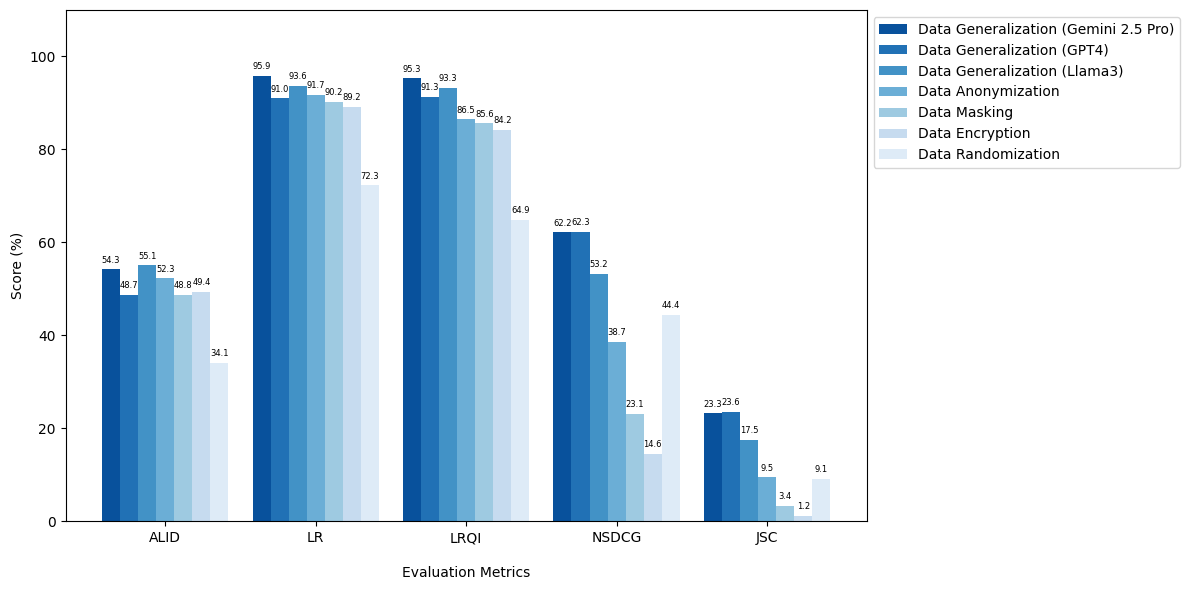

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Results
data = {
    "Data Anonymization": {'ALID': 52.276716, 'LR': 91.734134, 'LRQI': 86.51694618956569, 'JSC': 9.486496, 'NSDCG': 38.653542},
    "Data Encryption": {'ALID': 49.417448, 'LR': 89.218264, 'LRQI': 84.21828735318219, 'JSC': 1.226844, 'NSDCG': 14.550218},
    "Data Masking": {'ALID': 48.755338, 'LR': 90.219916, 'LRQI': 85.64060912319039, 'JSC': 3.396786, 'NSDCG': 23.11066},
    "Data Randomization": {'ALID': 34.132012, 'LR': 72.319864, 'LRQI': 64.89153509969954, 'JSC': 9.101062, 'NSDCG': 44.40661},
    "Data Generalization (Gemini 2.5 Pro)": {'ALID': 54.256458, 'LR': 95.879554, 'LRQI': 95.27244803063458, 'JSC': 23.266234, 'NSDCG': 62.169774},
    "Data Generalization (GPT4)": {'ALID': 48.720418, 'LR': 90.97883, 'LRQI': 91.31754510661564, 'JSC': 23.598556, 'NSDCG': 62.298188},
    "Data Generalization (Llama3)": {'ALID': 55.102216, 'LR': 93.626312, 'LRQI': 93.25791643760307, 'JSC': 17.512336, 'NSDCG': 53.203804},
}

metrics = ["ALID", "LR", "LRQI", "NSDCG", "JSC"]
techniques = list(data.keys())

# Colori più chiari
light_colors = [
    "#08519c", "#2171b5", "#4292c6", "#6baed6",
    "#9ecae1", "#c6dbef", "#deebf7"
]


# Ordina le tecniche in base alla media dei punteggi
techniques_sorted = sorted(
    techniques,
    key=lambda t: np.mean(list(data[t].values())),
    reverse=True
)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.12

# Disegna le barre ordinate
for i, technique in enumerate(techniques_sorted):
    values = [data[technique][metric] for metric in metrics]
    bars = ax.bar(x + i * width, values, width, label=technique, color=light_colors[i % len(light_colors)])
    # Aggiungi valori sopra le barre
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}",
            ha='center', va='bottom', fontsize=6
        )

# Configurazioni
ax.set_ylabel('Score (%)')
ax.set_xlabel('Evaluation Metrics', labelpad=15)
ax.set_xticks(x + width * (len(techniques) - 1) / 2)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 110)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
